In [ ]:
!wget https://datasets.simula.no/downloads/kvasir-seg.zip

--2023-01-30 16:08:10--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip’

kvasir-seg.zip      100%[===================>]  44.08M  9.94MB/s    in 4.7s    

2023-01-30 16:08:16 (9.47 MB/s) - ‘kvasir-seg.zip’ saved [46227172/46227172]



In [ ]:
!unzip kvasir-seg.zip

Archive:  kvasir-seg.zip
   creating: Kvasir-SEG/
  inflating: Kvasir-SEG/kavsir_bboxes.json  
   creating: Kvasir-SEG/images/
  inflating: Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg  
  inflating: Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49k.jpg  
  inflating: Kvasir-SEG/images/ck2bxlujamu330725szlc2jdu.jpg  
  inflating: Kvasir-SEG/images/ck2bxpfgxu2mk0748gsh7xelu.jpg  
  inflating: Kvasir-SEG/images/ck2bxqz3evvg20794iiyv5v2m.jpg  
  inflating: Kvasir-SEG/images/ck2bxskgxxzfv08386xkqtqdy.jpg  
  inflating: Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg  
  inflating: Kvasir-SEG/images/ck2395w2mb4vu07480otsu6tw.jpg  
  inflating: Kvasir-SEG/images/ck2da7fwcjfis07218r1rvm95.jpg  
  inflating: Kvasir-SEG/images/cjyzjzssvd8pq0838f4nolj5l.jpg  
  inflating: Kvasir-SEG/images/cjyzk8qieoboa0848ogj51wwm.jpg  
  inflating: Kvasir-SEG/images/cju5hi52odyf90817prvcwg45.jpg  
  inflating: Kvasir-SEG/images/cju5hjxaae3i40850h5z2laf5.jpg  
  inflating: Kvasir-SEG/images/cju5hl8nee8a40755fm8qjj

In [ ]:
import os
import numpy as np
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
def load_data(path, split = 0.1):
  images = sorted(glob(os.path.join(path, "images/*")))
  masks = sorted(glob(os.path.join(path, "masks/*")))
  total_size = len(images)
  valid_size = int(split * total_size)
  test_size = int(split * total_size)

  train_x, valid_x = train_test_split(images, test_size = valid_size, random_state = 42)
  train_y, valid_y = train_test_split(masks, test_size = valid_size, random_state = 42)

  train_x, test_x = train_test_split(images, test_size = test_size, random_state = 42)
  train_y, test_y = train_test_split(masks, test_size = test_size, random_state = 42)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  return x


def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  x = np.expand_dims(x, axis = -1)
  return x

In [ ]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y
  x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
  x.set_shape([256, 256, 3])
  y.set_shape([256, 256, 1])

  return x, y

In [ ]:
def tf_dataset(x, y, batch = 8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input, MaxPool2D, Concatenate
from tensorflow.keras.models import Model

In [ ]:
def conv_block(x, num_filters):
  x = Conv2D(num_filters, (4, 4), padding = "same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Conv2D(num_filters, (4, 4), padding = "same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

In [ ]:
def build_model():
    size = 256
    num_filters = [32, 64, 128, 256, 512, 1024]
    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs

    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [ ]:
model = build_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_135 (Conv2D)            (None, 256, 256, 32  1568        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_132 (Batch  (None, 256, 256, 32  128        ['conv2d_135[0][0]']             
 Normalization)                 )                                                           

In [ ]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

path = "/content/Kvasir-SEG"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

In [ ]:
def iou(y_true, y_pred):
  def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f, [y_true, y_pred], tf.float32)


In [ ]:
batch = 8
lr = 1e-4
epochs = 100
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

model = build_model()

opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", Recall(), Precision(), iou]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

callbacks = [
    ModelCheckpoint("/content/model.h5"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3),
    CSVLogger("/content/data.csv"),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
    ]

train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if(len(train_x) % batch != 0):
  train_steps += 1

if(len(valid_x) % batch != 0):
  valid_steps += 1



model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks,
    shuffle = False
)

Epoch 1/100
113/113 [==============================] - 96s 796ms/step - loss: 0.5120 - acc: 0.7729 - recall_1: 0.6236 - precision_1: 0.3797 - iou: 0.1894 - val_loss: 0.5319 - val_acc: 0.8185 - val_recall_1: 0.2265 - val_precision_1: 0.4436 - val_iou: 0.1462 - lr: 1.0000e-04
Epoch 2/100
113/113 [==============================] - 88s 781ms/step - loss: 0.3949 - acc: 0.8530 - recall_1: 0.4885 - precision_1: 0.5553 - iou: 0.2040 - val_loss: 0.5618 - val_acc: 0.8332 - val_recall_1: 0.1569 - val_precision_1: 0.5391 - val_iou: 0.1473 - lr: 1.0000e-04
Epoch 3/100
113/113 [==============================] - 89s 790ms/step - loss: 0.3624 - acc: 0.8676 - recall_1: 0.4845 - precision_1: 0.6210 - iou: 0.2197 - val_loss: 0.4347 - val_acc: 0.8319 - val_recall_1: 0.0892 - val_precision_1: 0.5302 - val_iou: 0.1399 - lr: 1.0000e-04
Epoch 4/100
113/113 [==============================] - 90s 792ms/step - loss: 0.3382 - acc: 0.8754 - recall_1: 0.4974 - precision_1: 0.6575 - iou: 0.2359 - val_loss: 0.4692 - 

In [ ]:
from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope

In [ ]:
def read_image_predict(path):
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  return x


def read_mask_predict(path):
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = np.expand_dims(x, axis = -1)
  return x

def mask_parse_predict(mask):
  mask = np.squeeze(mask)
  mask = [mask, mask, mask]
  mask = np.transpose(mask, (1, 2, 0))
  return mask


batch = 8
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
test_dataset = tf_dataset(test_x, test_y, batch=batch)
test_steps = len(test_x)//batch
if len(test_x) % batch != 0:
  test_steps += 1
  
with CustomObjectScope({'iou' : iou}):
  model= tf.keras.models.load_model("/content/model.h5")

model.evaluate(test_dataset, steps = test_steps)

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total = len(test_x)):
  x = read_image_predict(x)
  y = read_mask_predict(y)
  y_pred = model.predict(np.expand_dims(x, axis = 0))
  y_pred = y_pred[0] > 0.5
  h, w, _ = x.shape

  white_line = np.ones((h, 10, 3)) * 255.0
  all_images = [
              x * 255.0, white_line,
              mask_parse_predict(y), white_line,
              mask_parse_predict(y_pred) * 255.0
           ]
  image = np.concatenate(all_images, axis=1)
  cv2.imwrite(f"/content/{i}.png", image)

13/13 [==============================] - 3s 183ms/step - loss: 0.2199 - acc: 0.9220 - recall_1: 0.7022 - precision_1: 0.8410 - iou: 0.4909


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 393ms/step


  1%|          | 1/100 [00:00<00:47,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:25,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 3/100 [00:00<00:18,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:15,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 5/100 [00:00<00:13,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:01<00:12,  7.66it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:01<00:10,  8.75it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 9/100 [00:01<00:10,  8.87it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:01<00:10,  8.94it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:09,  9.42it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:09,  9.49it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:02<00:08,  9.54it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 17/100 [00:02<00:08,  9.57it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:02<00:08,  9.44it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 19/100 [00:02<00:08,  9.50it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:02<00:08,  9.13it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 22/100 [00:02<00:08,  9.18it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 23/100 [00:02<00:08,  8.94it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 24/100 [00:02<00:08,  9.11it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 25/100 [00:03<00:08,  9.01it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:03<00:08,  9.11it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 27/100 [00:03<00:07,  9.19it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:03<00:08,  8.87it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 29/100 [00:03<00:08,  8.79it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 30/100 [00:03<00:07,  9.04it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:03<00:07,  9.46it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 33/100 [00:03<00:06,  9.57it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:04<00:06,  9.61it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 35/100 [00:04<00:07,  9.28it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:04<00:06,  9.25it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:04<00:06,  9.44it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 39/100 [00:04<00:06,  9.31it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 41/100 [00:04<00:06,  9.71it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:04<00:05,  9.67it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 43/100 [00:04<00:05,  9.74it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 45/100 [00:05<00:05,  9.72it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:05<00:05,  9.44it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 47/100 [00:05<00:05,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:05<00:05,  9.46it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 49/100 [00:05<00:05,  9.10it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:05<00:05,  9.08it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:05<00:05,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 53/100 [00:06<00:05,  9.06it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 54/100 [00:06<00:05,  9.02it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 55/100 [00:06<00:04,  9.01it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:06<00:04,  8.96it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 57/100 [00:06<00:04,  8.89it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 59/100 [00:06<00:04,  9.52it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:06<00:04,  9.48it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 61/100 [00:06<00:04,  9.37it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:07<00:04,  9.19it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 63/100 [00:07<00:04,  9.24it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:07<00:03,  9.19it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 65/100 [00:07<00:03,  9.10it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:07<00:03,  8.94it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 67/100 [00:07<00:03,  8.99it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:07<00:03,  8.99it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 70/100 [00:07<00:03,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 71/100 [00:07<00:03,  9.58it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:08<00:02,  9.45it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 73/100 [00:08<00:02,  9.52it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 75/100 [00:08<00:02,  9.56it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:08<00:02,  9.38it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:08<00:02,  9.75it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 79/100 [00:08<00:02,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:08<00:02,  9.42it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 81/100 [00:09<00:02,  9.32it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 83/100 [00:09<00:01,  9.36it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 85/100 [00:09<00:01,  9.70it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:09<00:01,  9.52it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 87/100 [00:09<00:01,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:09<00:01,  9.20it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:10<00:01,  9.42it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 91/100 [00:10<00:00,  9.21it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:10<00:00,  9.14it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 93/100 [00:10<00:00,  9.30it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:10<00:00,  9.22it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 95/100 [00:10<00:00,  9.36it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 96/100 [00:10<00:00,  9.45it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 97/100 [00:10<00:00,  9.48it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:10<00:00,  9.52it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 99/100 [00:10<00:00,  9.16it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


In [ ]:
import pandas as pd
df = pd.read_csv("data.csv")

In [ ]:
df

,epoch,acc,iou,loss,lr,precision_1,recall_1,val_acc,val_iou,val_loss,val_precision_1,val_recall_1
0,0,0.772935,0.189387,0.511980,1.000000e-04,0.379742,0.623559,0.818481,0.146208,0.531921,0.443588,0.226474
1,1,0.853043,0.203971,0.394916,1.000000e-04,0.555282,0.488459,0.833220,0.147263,0.561784,0.539108,0.156893
2,2,0.867618,0.219670,0.362438,1.000000e-04,0.620996,0.484511,0.831915,0.139882,0.434730,0.530240,0.089200
3,3,0.875448,0.235941,0.338229,1.000000e-04,0.657507,0.497359,0.787907,0.259780,0.469157,0.434216,0.705014
4,4,0.882931,0.255509,0.316545,1.000000e-04,0.693240,0.511818,0.733277,0.274979,0.743018,0.376350,0.800520
5,5,0.893677,0.281834,0.293282,1.000000e-04,0.737681,0.549661,0.869206,0.248084,0.321251,0.699886,0.426131
6,6,0.899141,0.302087,0.276878,1.000000e-04,0.760647,0.568408,0.855946,0.180680,0.358250,0.844904,0.190004
7,7,0.905453,0.326215,0.260175,1.000000e-04,0.779561,0.600609,0.872900,0.240127,0.318614,0.818767,0.332634
8,8,0.913850,0.357993,0.239193,1.000000e-04,0.806734,0.637931,0.879084,0.316082,0.306181,0.716888,0.512658
9,9,0.917057,0.379419,0.225747,1.000000e-04,0.818396,0.649793,0.864406,0.245339,0.342180,0.709914,0.365112


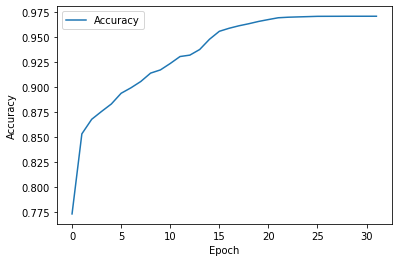

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df["epoch"], df["acc"], label = "Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()